In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [96]:
# Parameters
beta = 5
sdim = 32

In [97]:
# Set Seed
np.random.seed(117);

In [98]:
# Build power spectrum 
f = [x/sdim for x in range(1, int(sdim/2)+1)] + [x/sdim for x in range(-int(sdim/2), 0)]
u = np.reshape(f, (sdim, 1))
v = np.reshape(f, (1, sdim))
w = np.reshape(f, (sdim, 1, 1))
pattern = (u**2 + v**2 + w**2)**(-beta/2)

In [99]:
# Noise and ifft
phases = np.random.normal(0, 255, size=[sdim, sdim, sdim]);
pattern = np.fft.ifftn(pattern**0.5 * (np.cos(2*np.pi*phases)+1j*np.sin(2*np.pi*phases)))

In [100]:
# Normalize result
pattern = np.real(pattern)
pattern = (pattern-np.amin(pattern))/np.amax(pattern-np.amin(pattern))

In [101]:
# Binarize result for box counting
threshold, upper, lower = 0.5, 1, 0
pattern = np.asarray(np.where(pattern>threshold, upper, lower))

In [102]:
height = sdim+1
# Get subdivision sizes
n = 2**np.floor(np.log(height)/np.log(2))  # Greatest power of 2 less than or equal to canvas
# Extract the exponent
n = int(np.log(n)/np.log(2))
boxes = 2**np.arange(n-1, 0, -1)
boxcounts = {box: 0 for box in boxes}  # Dictionary to store counts for each box size

In [129]:
def boxcount3d(sizes, save=False, visualize=False):
    for s in sizes:

        # Reset box counter
        bc = 0

        # Make list of box corners
        corners = []
        for z in range(0, height, int(height/s)):
            for y in range(0, height, int(height/s)):
                for x in range(0, height, int(height/s)):
                    corners.append([x, y, z])


        # Detect edges and draw box
        for c in range(1, len(corners)-s**3):
            boxval = np.mean(pattern[corners[c-1][0]:corners[c][0], corners[c-1][1]:corners[c+s][1], corners[c-1][2]:corners[c+s**3][2]])
            if 0.0 < boxval < 1.0:
                bc += 1

        boxcounts[s] = bc
    
    return boxcounts

#print(corners[c-1][0], corners[c][0])
#print(corners[c-1][1], corners[c+s][1])
#print(corners[c-1][2], corners[c+s**3][2])

In [131]:
counts = boxcount3d(boxes)

2.1672761485052088


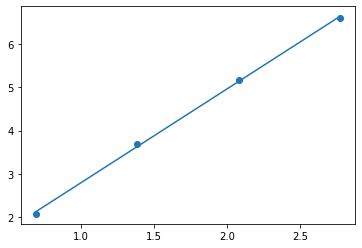

In [132]:
# Get slope and plot
x = [x for x in counts.keys()]
y = [y for y in counts.values()]

m, b = np.polyfit(np.log(x), np.log(y), 1)
print(m)

#plt.xscale("log")
#plt.yscale("log")

plt.plot(np.log(x), m*np.log(x)+b, label=f"{round(m, 2)}")
plt.scatter(np.log(x), np.log(y))

In [27]:
def fractal_dimension_3d(Z, threshold=0.9):

    # Only for 3d volume
    assert(len(Z.shape) == 3)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):

        reducer = np.add.reduceat(np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0), np.arange(0, Z.shape[1], k), axis=1)

        S = np.add.reduceat(reducer, np.arange(0, Z.shape[2], k), axis=2)
        #print(S.shape)
        
        # We count non-empty (0) and non-full boxes (k*k) (is this right for 3d?)
        return len(np.where((S > 0) & (S < k*k*k))[0])

    #Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n-1, 0, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        #print(size)
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    m, b = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -m, b, sizes, counts

def fractal_dimension_2d(Z, threshold=0.9):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)
        #print(S.shape)
        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    #Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    #sizes = 2**np.arange(n-1, 0, -1)
    sizes = np.arange(p, 0, -2)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        #print(size)
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    m, b = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -m, b, sizes, counts

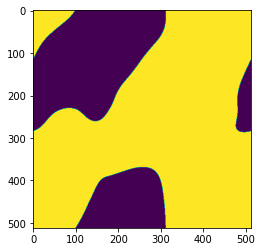

In [28]:
test2d = pattern[-1,:,:]
plt.imshow(test2d)

In [29]:
avg2d = []

for i in range(len(pattern)):
  slope2d, intercept2d, sz2d, count2d = fractal_dimension_2d(pattern[i,:,:])
  avg2d.append(slope2d)

slope2d = np.mean(avg2d)

In [32]:
np.min(avg2d)

0.9486624125014814

In [33]:
np.max(avg2d)

1.1814395599079641

In [30]:
fractal_dimension_3d(np.asarray(pattern))

(1.9856629261998877,
 13.605573590073444,
 array([256, 128,  64,  32,  16,   8,   4,   2]),
 [8, 61, 257, 1029, 4040, 15129, 51809, 138182])

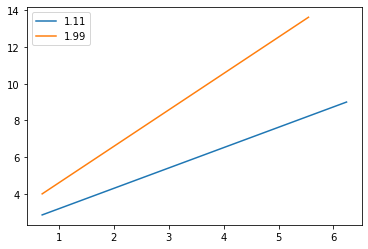

In [31]:
plt.plot(np.log(sz2d), slope2d*np.log(sz2d)+np.log(intercept2d), label=f"{round(slope2d, 2)}")

slope3d, intercept3d, sz3d, count3d = fractal_dimension_3d(np.asarray(pattern))
plt.plot(np.log(sz3d), slope3d*np.log(sz3d)+np.log(intercept3d), label=f"{round(slope3d, 2)}")

leg = plt.legend()
plt.show()